# Global preparations

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:7'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
logger = logging.getLogger('stdout_logger')
logger.setLevel(logging.INFO)
if not logger.hasHandlers():
    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setFormatter(logging.Formatter(fmt='%(asctime)s|%(levelname)s|%(message)s'))
    logger.addHandler(stdout_handler)

# MNIST preparation

Let's read the MNIST dataset and represent it in sparse form

In [4]:
mnist_dataset_dir = 'mnist'

import torchvision.transforms as T

# transform = T.Normalize((0.1307,), (0.3081,))

mnist_train_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=True, download=True
)
mnist_test_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=False, download=True
)
mnist_train_data_device = mnist_train_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_test_data_device = mnist_test_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_train_targets_device = mnist_train_dataset.targets.to(device=device)
mnist_test_targets_device = mnist_test_dataset.targets.to(device=device)

mnist_train_dataset = TensorDataset(
    mnist_train_data_device, mnist_train_targets_device
)
mnist_test_dataset = TensorDataset(
    mnist_test_data_device, mnist_test_targets_device
)

# mnist_train_dataset = TensorDataset(
#     transform(mnist_train_data_device), mnist_train_targets_device
# )
# mnist_test_dataset = TensorDataset(
#     transform(mnist_test_data_device), mnist_test_targets_device
# )

In [5]:
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_train_dataset,
    batch_size=1, shuffle=True
)

example_data, example_targets = next(iter(mnist_test_loader))
to_pil_image(example_data[0])

In [6]:
patch_h = patch_w = 28
input_shape = (patch_h, patch_w)
clustering_dim = 44

In [7]:
example_data.shape

torch.Size([1, 28, 28])

# Baseline MLP

In [9]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class BaselineMLP(nn.Module):
    def __init__(self, device, n_inputs, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, hidden_dim, bias=False, device=device)
        self.fc2 = nn.Linear(hidden_dim, 10, bias=False, device=device)
        
    def forward(self, x):
        x1 = x / (x.norm(dim=-1, keepdim=True) + 1e-16)
        x2 = F.relu(self.fc1(x1))
        return self.fc2(x2)
    
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc = nn.Linear(128 * 7 * 7, 10)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.max_pool2d(x, 2)      # 28→14
        x = F.relu(self.c3(x))
        x = F.max_pool2d(x, 2)      # 14→7
        x = x.flatten(1)
        return self.fc(self.drop(x))

In [7]:
baseline_net = BaselineMLP(device, input_shape[0] * input_shape[1], clustering_dim**2)

In [8]:
baseline_net = MNIST_CNN()
baseline_net.to(device=device)

MNIST_CNN(
  (c1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=6272, out_features=10, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)

In [28]:
total = sum(p.numel() for p in baseline_net.parameters())
trainable = sum(p.numel() for p in baseline_net.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 155402
trainable: 155402
frozen: 0


In [9]:
optimizer = optim.Adam(baseline_net.parameters(), lr=0.0003)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    baseline_net.train()
    train_loader = torch.utils.data.DataLoader(
        mnist_train_dataset, batch_size=64, shuffle=True,
        
    )
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
        optimizer.zero_grad()
        output = baseline_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    
    baseline_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = baseline_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

Epoch 1 Train/test accuracy: 94.58/98.43
Epoch 2 Train/test accuracy: 98.35/98.98
Epoch 3 Train/test accuracy: 98.75/98.77
Epoch 4 Train/test accuracy: 99.04/99.18
Epoch 5 Train/test accuracy: 99.16/99.17
Epoch 6 Train/test accuracy: 99.34/99.15
Epoch 7 Train/test accuracy: 99.42/99.20
Epoch 8 Train/test accuracy: 99.44/99.23
Epoch 9 Train/test accuracy: 99.48/99.23
Epoch 10 Train/test accuracy: 99.56/99.28
Epoch 11 Train/test accuracy: 99.64/99.31
Epoch 12 Train/test accuracy: 99.67/99.37
Epoch 13 Train/test accuracy: 99.66/99.28


KeyboardInterrupt: 

# Simple ANDN network

#### Similar to *Krotov,Hopfield, 2019 "Unsupervised Learning by Competing Hidden Units"*

In [68]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer, SynapseMeta

receptive_field_shape=(28, 28)
receptive_field_stride_shape=(28, 28)
output_kernel_shape=(clustering_dim, clustering_dim)
final_output_shape = (1, 10)
synapse_meta_1 = SynapseMeta(
    min_weight=-2.0,
    max_weight=2.0,
    initial_weight=2.0,
    initial_noise_level=-4.0
)

synapse_meta_2 = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

class ANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.layer1 = Conv2DANDNLayer(
            input_shape=input_shape,
            inhibition_grid_shape=None,
            receptive_field_shape=receptive_field_shape,
            receptive_field_stride_shape=receptive_field_stride_shape,
            output_kernel_shape=output_kernel_shape,
            backprop_hebb_ratio_on_torch_backward=0.8,
            #anti_hebb_coeff=0.4,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2 = Conv2DANDNLayer(
            input_shape=self.layer1.output_shape(),
            inhibition_grid_shape=output_kernel_shape,
            receptive_field_shape=self.layer1.output_shape(),
            receptive_field_stride_shape=self.layer1.output_shape(),
            output_kernel_shape=final_output_shape,
            backprop_hebb_ratio_on_torch_backward=0.0,
            synapse_meta=synapse_meta_2,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer1.set_descendant_andn_layer(self.layer2)

    def forward(self, x):
        x = x / (x.norm(dim=(-1, -2), keepdim=True) + 1e-16)
        return self.layer2(self.layer1(x)).squeeze(1)

In [69]:
andn_net = ANDNNet(device)
andn_net

ANDNNet(
  (layer1): ANDNLayer(784 inputs, 0 detectors, 1936 outputs, 1517824 synapses, ANDNDataManager(host_device: 18849672, 18849672; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 1517824; n_detectors: 0; first_synapse_id: 229136; last_synapse_id: 6494852; n_forward_groups: 24304; n_backward_groups: 25168))
  (layer2): ANDNLayer(1936 inputs, 1 detectors, 10 outputs, 19360 synapses, ANDNDataManager(host_device: 476368, 476368; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 19360; n_detectors: 1; first_synapse_id: 218304; last_synapse_id: 311220; n_forward_groups: 1936; n_backward_groups: 310))
)

In [72]:
optimizer = optim.Adam(andn_net.parameters(), lr=0.001)
#optimizer = optim.SGD(andn_net.parameters(), lr=0.001, momentum=0.95)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    andn_net.train()
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
        optimizer.zero_grad()
        output = andn_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    
    andn_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = andn_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

Epoch 1 Train/test accuracy: 91.74/91.56
Epoch 2 Train/test accuracy: 92.36/92.22
Epoch 3 Train/test accuracy: 92.61/92.72
Epoch 4 Train/test accuracy: 92.89/92.01
Epoch 5 Train/test accuracy: 93.32/93.30
Epoch 6 Train/test accuracy: 93.50/93.45
Epoch 7 Train/test accuracy: 93.74/93.53
Epoch 8 Train/test accuracy: 93.95/93.86
Epoch 9 Train/test accuracy: 94.07/93.77
Epoch 10 Train/test accuracy: 94.23/94.17
Epoch 11 Train/test accuracy: 94.17/94.39
Epoch 12 Train/test accuracy: 94.36/93.93
Epoch 13 Train/test accuracy: 94.49/94.67
Epoch 14 Train/test accuracy: 94.49/94.32
Epoch 15 Train/test accuracy: 94.63/94.37
Epoch 16 Train/test accuracy: 94.65/94.45


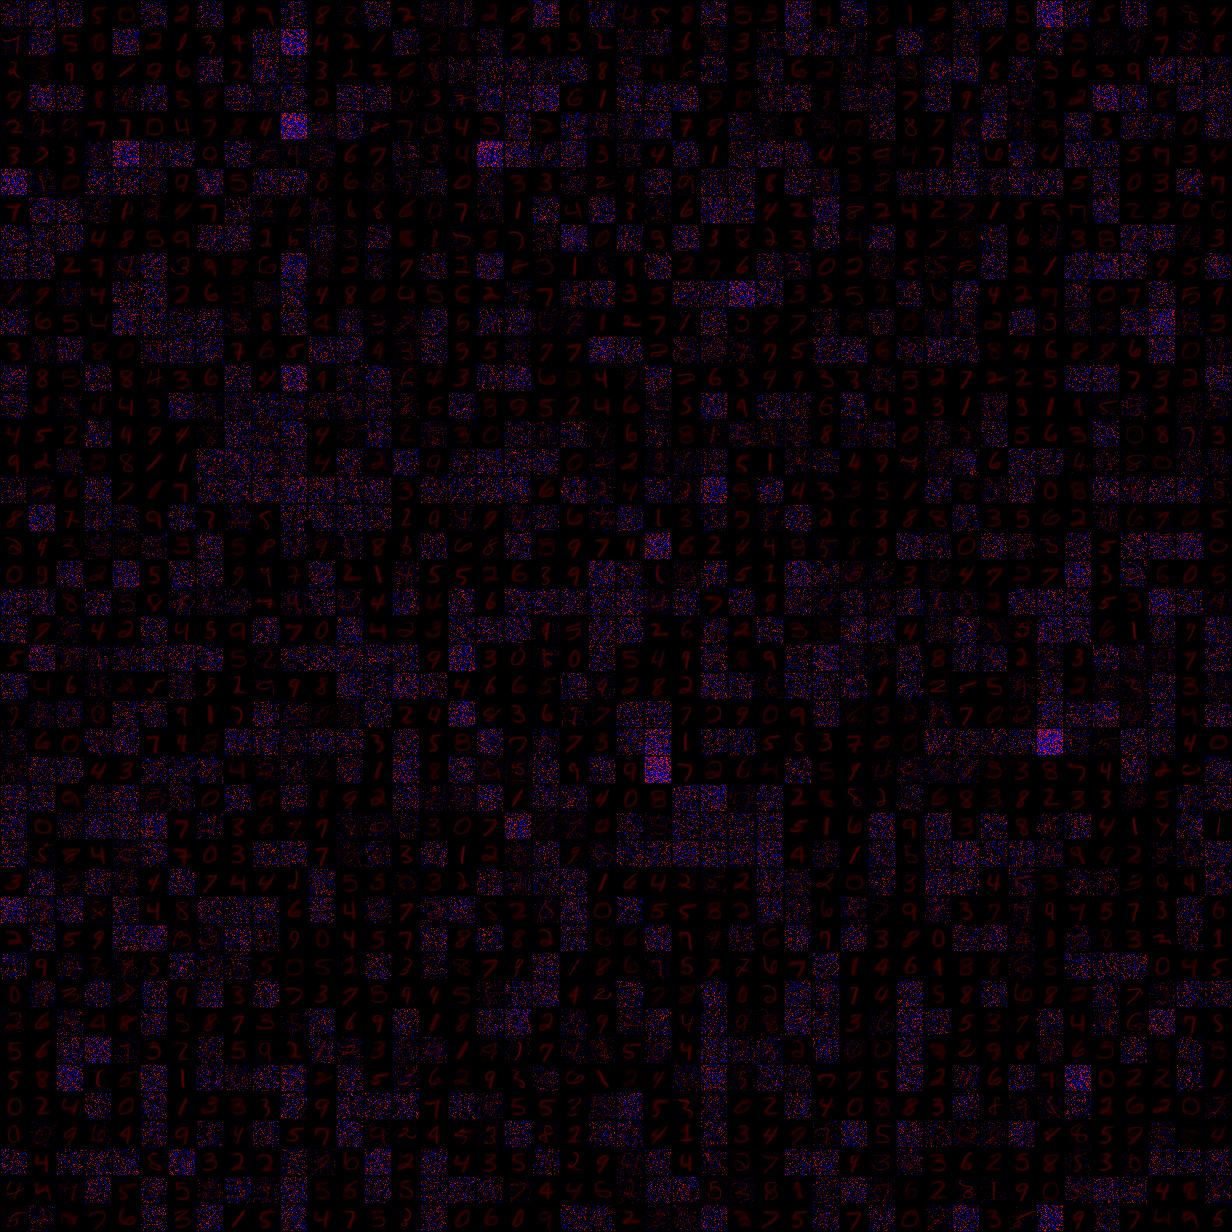

In [73]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue

output_shape = andn_net.layer1.output_shape()
target_image = torch.zeros([output_shape[0] * (patch_h + 2), output_shape[1] * (patch_w + 2)])
weights = andn_net.layer1.export_weights()

for i in range(output_shape[0]):
    for j in range(output_shape[1]):
        target_image[
            i * (patch_h + 2) + 1:i * (patch_h + 2) + patch_h + 1,
            j * (patch_w + 2) + 1:j * (patch_w + 2) + patch_w + 1
        ] = weights[i, j]

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0) * 2)
img.resize(
    [
        output_shape[0] * receptive_field_shape[0], 
        output_shape[1] * receptive_field_shape[1]
    ], Image.NEAREST
)

# Layered ANDN network

In [80]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer, SynapseMeta

input_shape=(28, 28)
final_output_shape = (1, 10)
cl_d = 6
rf_d = 5
synapse_meta_1 = SynapseMeta(
    min_weight=0.0,
    max_weight=10.0,
    initial_weight=1.0,
    initial_noise_level=-10.0
)

synapse_meta_2 = SynapseMeta(
    learning_rate=0.1,
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

class ANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.layer1 = Conv2DANDNLayer(
            input_shape=input_shape,
            inhibition_grid_shape=None,
            receptive_field_shape=(rf_d, rf_d),
            receptive_field_stride_shape=(1, 1),
            output_kernel_shape=(cl_d, cl_d),
            backprop_hebb_ratio_on_torch_backward=1.0,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2 = Conv2DANDNLayer(
            input_shape=self.layer1.output_shape(),
            inhibition_grid_shape=(cl_d, cl_d),
            receptive_field_shape=(rf_d * cl_d, rf_d * cl_d),
            receptive_field_stride_shape=(cl_d, cl_d),
            output_kernel_shape=(cl_d, cl_d),
            backprop_hebb_ratio_on_torch_backward=1.0,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer1.set_descendant_andn_layer(self.layer2)
        self.layer3 = Conv2DANDNLayer(
            input_shape=self.layer2.output_shape(),
            inhibition_grid_shape=(cl_d, cl_d),
            receptive_field_shape=(rf_d * cl_d, rf_d * cl_d),
            receptive_field_stride_shape=(cl_d, cl_d),
            output_kernel_shape=(cl_d, cl_d),
            backprop_hebb_ratio_on_torch_backward=1.0,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2.set_descendant_andn_layer(self.layer3)
        self.layer4 = Conv2DANDNLayer(
            input_shape=self.layer3.output_shape(),
            inhibition_grid_shape=(cl_d, cl_d),
            receptive_field_shape=self.layer3.output_shape(),
            receptive_field_stride_shape=self.layer2.output_shape(),
            output_kernel_shape=final_output_shape,
            backprop_hebb_ratio_on_torch_backward=0.0,
            synapse_meta=synapse_meta_2,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer3.set_descendant_andn_layer(self.layer4)

    def forward(self, x):
        x = x / (x.norm(dim=(-1, -2), keepdim=True) + 1e-16)
        return self.layer4(self.layer3(self.layer2(self.layer1(x)))).squeeze(1)

In [81]:
layered_andn_net = ANDNNet(device)
layered_andn_net

ANDNNet(
  (layer1): ANDNLayer(784 inputs, 0 detectors, 20736 outputs, 518400 synapses, ANDNDataManager(host_device: 7222376, 7222376; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 518400; n_detectors: 0; first_synapse_id: 680336; last_synapse_id: 2823204; n_forward_groups: 8660; n_backward_groups: 20736))
  (layer2): ANDNLayer(20736 inputs, 576 detectors, 14400 outputs, 12960000 synapses, ANDNDataManager(host_device: 160212360, 160212360; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 12960000; n_detectors: 576; first_synapse_id: 1090064; last_synapse_id: 54663812; n_forward_groups: 216720; n_backward_groups: 216000))
  (layer3): ANDNLayer(14400 inputs, 400 detectors, 9216 outputs, 8294400 synapses, ANDNDataManager(host_device: 102633096, 102633096; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 8294400; n_detectors: 400; first_synapse_id:

In [82]:
total = sum(p.numel() for p in layered_andn_net.parameters())
trainable = sum(p.numel() for p in layered_andn_net.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 22612064
trainable: 22612064
frozen: 0


In [83]:
optimizer = optim.Adam(layered_andn_net.parameters(), lr=0.001)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    layered_andn_net.train()
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=128, shuffle=True)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
        optimizer.zero_grad()
        output = layered_andn_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    
    layered_andn_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = layered_andn_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

Epoch 1 Train/test accuracy: 50.58/81.34
Epoch 2 Train/test accuracy: 87.04/91.09
Epoch 3 Train/test accuracy: 91.94/93.56
Epoch 4 Train/test accuracy: 94.10/94.51


KeyboardInterrupt: 

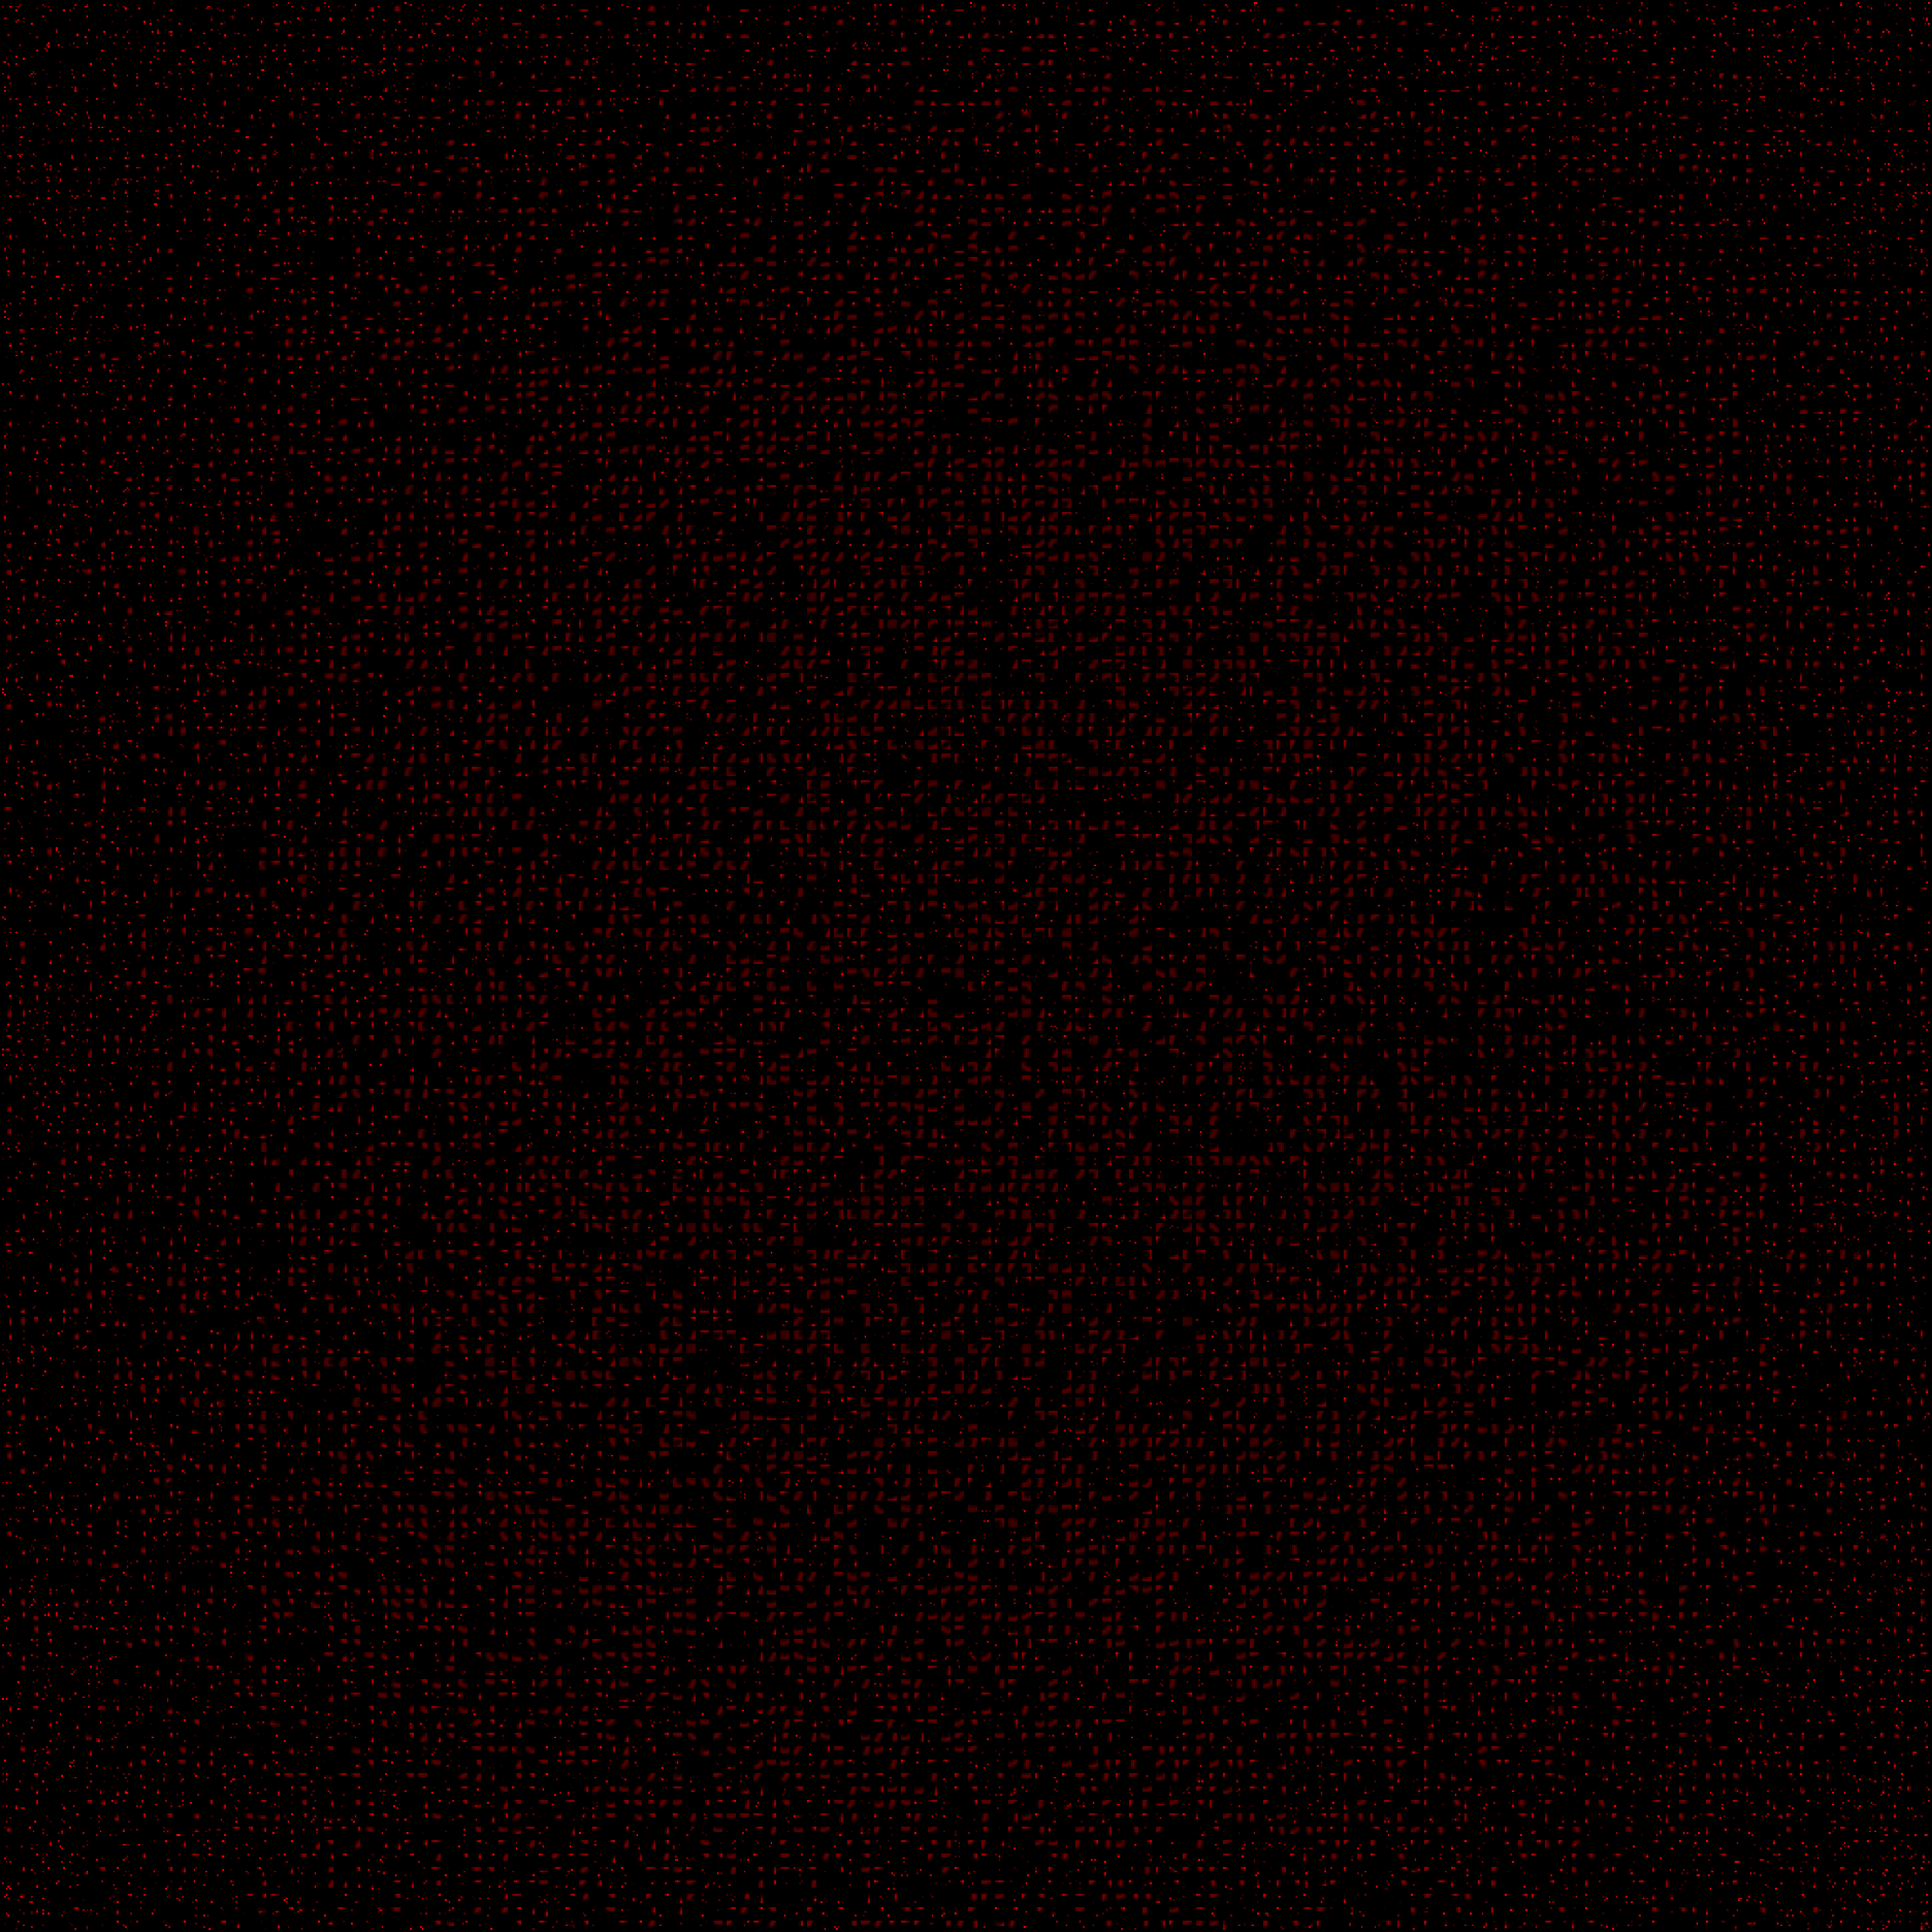

In [84]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue

output_shape = layered_andn_net.layer1.output_shape()
patch_h, patch_w = (rf_d, rf_d)
target_image = torch.zeros([output_shape[0] * (rf_d + 2), output_shape[1] * (rf_d + 2)])
weights = layered_andn_net.layer1.export_weights()

for i in range(output_shape[0]):
    for j in range(output_shape[1]):
        target_image[
            i * (rf_d + 2) + 1:i * (rf_d+ 2) + rf_d + 1,
            j * (rf_d + 2) + 1:j * (rf_d + 2) + rf_d + 1
        ] = weights[i, j]

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        output_shape[0] * rf_d * 4, 
        output_shape[1] * rf_d * 4
    ], Image.NEAREST
)

In [6]:
import torch

B, N, M = 4, 10, 6

# make independent random noise per batch and sort to get unique order
noise = torch.rand(B, N * (N - 1), device=device)
idx = noise.argsort(dim=1)[:, :M]  # each row = independent permutation

# decode to ordered pairs
i = idx // (N - 1)
j = idx % (N - 1)
j[j >= i] += 1

pairs = torch.stack((i, j), dim=-1)  # [B, M, 2]

In [13]:
noise.argsort(dim=1).shape

torch.Size([4, 90])

In [18]:
x = 7
x & (x - 1)

6

In [19]:
64 * 25 * 24 * 24

921600

In [20]:
784 * 2304

1806336

In [21]:
24 * 24 * 64

36864

In [ ]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer, SynapseMeta

synapse_meta_1 = SynapseMeta(
    min_weight=0.0,
    max_weight=10.0,
    initial_weight=1.0,
    initial_noise_level=-10.0
)

synapse_meta_2 = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

class ANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.layer1 = Conv2DANDNLayer(
            input_shape=input_shape,
            inhibition_grid_shape=None,
            receptive_field_shape=(5, 5),
            receptive_field_stride_shape=(1, 1),
            output_kernel_shape=(6, 6),
            backprop_hebb_ratio_on_torch_backward=1.0,
            #anti_hebb_coeff=0.4,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2 = Conv2DANDNLayer(
            input_shape=self.layer1.output_shape(),
            inhibition_grid_shape=(6, 6),
            receptive_field_shape=(5 * 6, 5 * 6),
            receptive_field_stride_shape=(6, 6),
            output_kernel_shape=(6, 6),
            backprop_hebb_ratio_on_torch_backward=1.0,
            #anti_hebb_coeff=0.4,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer3 = Conv2DANDNLayer(
            input_shape=self.layer2.output_shape(),
            inhibition_grid_shape=(6, 6),
            receptive_field_shape=(5 * 6, 5 * 6),
            receptive_field_stride_shape=(6, 6),
            output_kernel_shape=(6, 6),
            backprop_hebb_ratio_on_torch_backward=1.0,
            #anti_hebb_coeff=0.4,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer4 = Conv2DANDNLayer(
            input_shape=self.layer3.output_shape(),
            inhibition_grid_shape=output_kernel_shape,
            receptive_field_shape=self.layer1.output_shape(),
            receptive_field_stride_shape=self.layer1.output_shape(),
            output_kernel_shape=final_output_shape,
            backprop_hebb_ratio_on_torch_backward=0.0,
            synapse_meta=synapse_meta_2,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer1.set_descendant_andn_layer(self.layer2)

    def forward(self, x):
        # x = x / (x.norm(dim=(-1, -2), keepdim=True) + 1e-16)
        return self.layer2(self.layer1(x)).squeeze(1)